# Detecção de Fraudes em Pagamentos - Data Analysis

### Bibliotecas

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input/datasetinf'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from ydata_profiling import ProfileReport
from IPython.display import display, HTML
import matplotlib.pyplot as plt

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter

# check xgboost version
from xgboost import XGBClassifier

import timeit
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/datasetinf/describe.csv
/kaggle/input/datasetinf/PS_20174392719_1491204439457_log.csv
/kaggle/input/datasetinf/paysim_predicted.csv


/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


### Layout

In [1]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16,
    'axes.titlesize': 18, 'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(rc=rc)
sns.set_style("darkgrid")
sns.set_palette("pastel")

### Configurações

In [41]:
#pd.set_option('max_columns', 200)
pd.options.display.max_columns = 200 

# Define um valor maior para a largura máxima das colunas
pd.options.display.max_colwidth = 1000

# Definindo o formato para exibição das variáveis numéricas
pd.options.display.float_format = '{:.2f}'.format

seed = 42
np.random.seed(seed)

### Funções

In [4]:
def format_number(number):
    if number >= 1000:
        return f"{number:.0f}"
    else:
        return f"{number:.2f}"

In [5]:
def check_time(start, end):
    seg = end - start
    dias = seg // 86400
    Seg_Restantes_Após_Dias = seg % 86400
    horas = Seg_Restantes_Após_Dias // 3600         # Divisão inteira
    Seg_Restantes_Apos_Hora = seg % 3600            # Resto da divisão por 3600
    minutos = Seg_Restantes_Apos_Hora // 60         # Divisão inteira dos segundos restantes
    Seg_Restantes_Apos_Minutos = seg % 60
    #print(minutos,'minutos','e', '%.2f' % Seg_Restantes_Apos_Minutos,'segundos')
    print(dias,'dias', horas,'horas', minutos,'minutos','e', '%.2f' % Seg_Restantes_Apos_Minutos,'segundos')

start=timeit.default_timer()

In [7]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [75]:
# Função para analisar a relação entre cada variável categórica e cada variável numérica com describe
def describe_correlation_categorical_numerical(df, categorical_variables, numerical_variables):
    for num_var in numerical_variables:
        print(f"Estatísticas descritivas para '{num_var}' por cada categoria:")

        # Agrupando por variável numérica e extraindo as estatísticas descritivas para cada categoria
        desc_stats = df.groupby(categorical_variables)[num_var].describe().T
        print(desc_stats)
        print("\n")

In [46]:
# Função para analisar a relação entre cada variável categórica e cada variável numérica com boxplots
def plot_correlation_categorical_numerical(df, categorical_variables, numerical_variables):
    num_cols = 2  # Número de colunas na matriz de gráficos
    num_plots = len(categorical_variables) * len(numerical_variables)
    num_rows = -(-num_plots // num_cols)  # Arredonda para cima a divisão

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    axes = axes.flatten()  # Achatando a matriz de eixos para facilitar o acesso

    for i, cat_var in enumerate(categorical_variables):
        for j, num_var in enumerate(numerical_variables):
            ax = axes[i * num_cols + j]  # Seleciona o eixo apropriado
            sns.boxplot(x=cat_var, y=num_var, data=df, ax=ax)
            ax.set_title(f'Relação entre {cat_var} e {num_var}')
            ax.ticklabel_format(style='plain', axis='y')

    # Remove eixos desnecessários caso o número de gráficos seja menor que num_rows * num_cols
    for k in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes[k])

    plt.tight_layout()
    plt.show()

In [58]:
# Criando uma lista de variaveis categoricas
def var_cat(df):
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)
    print("Categorical variables: ", len(object_cols))
    print(object_cols)

In [64]:
# Criando uma lista de variaveis numéricas
def var_num(df):
    numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
    print("Numerical variables: ", len(numerical_cols))
    print(numerical_cols)

***
# 1) Definição do problema e objetivo do projeto

## 1.1) Contexto

Apresentamos um conjunto de dados sintético gerado usando o simulador denominado PaySim como uma abordagem para tal problema. PaySim usa dados agregados do conjunto de dados privado para gerar um conjunto de dados sintético que se assemelha à operação normal das transações e injeta comportamento malicioso para avaliar posteriormente o desempenho dos métodos de detecção de fraude.

## 1.2) Sobre o Conteudo

PaySim simula transações de dinheiro móvel com base em uma amostra de transações reais extraídas de um mês de registros financeiros de um serviço de dinheiro móvel implementado em um país africano. Os registos originais foram fornecidos por uma empresa multinacional, fornecedora do serviço financeiro móvel que funciona atualmente em mais de 14 países em todo o mundo.

Este conjunto de dados sintético foi reduzido em 1/4 do conjunto de dados original e foi criado apenas para Kaggle.

## 1.1) Dicionario de dados

In [9]:
dicionario = pd.read_csv('/kaggle/input/datasetinf/describe.csv', delimiter=';', header=None, encoding='latin1', index_col=None)
dicionario

0                                                                                                                                                                                                                                                                                                             1
0             step                                                                                                                                                                                  mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo equivale a 1 hora. Total de passos 744 (simulação de 30 dias).
1             type                                                                                                                                                                                                                                                          CASH-IN, CASH-OUT, DÉBITO, PAGAMENTO e TRANSFERÊNCIA.
2           amount                                                                                                                                                                                                                                                                             valor da transação em moeda local.
3         nameOrig                                                                                                                                                                                                                                                                                cliente que iniciou a transação
4    oldbalanceOrg                                                                                                                                                                                                                                                                               saldo inicial antes da transação
5   newbalanceOrig                                                                                                                                                                                                                                                                                   novo saldo após a transação.
6         nameDest                                                                                                                                                                                                                                                                      cliente que é o destinatário da transação
7   oldbalanceDest                                                                                                                                                                               destinatário do saldo inicial antes da transação. Observe que não há informações para clientes que iniciam com M (Comerciantes).
8   newbalanceDest                                                                                                                                                                                    novo destinatário do saldo após a transação. Observe que não há informações para clientes que iniciam com M (Comerciantes).
9          isFraud     São as transações realizadas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar assumindo o controle das contas dos clientes e tentando esvaziar os fundos transferindo para outra conta e depois sacando do sistema.
10  isFlaggedFraud                                                                          O modelo de negócio visa controlar transferências massivas de uma conta para outra e sinalizar tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.

***
# 2) Coleta e preparação dos dados

## 2.1) Coleta dos dados - Modelagem

In [10]:
# treinamento
df = pd.read_csv('/kaggle/input/datasetinf/PS_20174392719_1491204439457_log.csv')

# isFlaggedFraud foi excluido pois o modelo pode usar esta coluna como referencia para prever fraudes
df = df.drop(['isFlaggedFraud'],axis=1)

print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36  M1979787155             0.0             0.0        0
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72  M2044282225             0.0             0.0        0
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   C553264065             0.0             0.0        1
3     1  CASH_OUT    181.00   C840083671          181.0            0.00    C38997010         21182.0             0.0        1
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86  M1230701703             0.0             0.0        0


In [39]:
df.shape

(6362620, 10)

### 2.2) Checar dados faltantes

In [14]:
just_check_nan(df)

Dados com NaN:
Series([], dtype: int64)

columns_with_nan.shape (0,)



***
# 3) Análise exploratória dos dados

In [15]:
dados_analysis = ProfileReport(df, title="Profiling Report", progress_bar=True, infer_dtypes=False)
profile_td_html = dados_analysis.to_html()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
display(HTML(profile_td_html))

***
# 4) Mostrando a correlação entre os Tipo de Transação (type) e variáveis categoricas

## 4.1) Variaveis Categoricas

In [67]:
var_cat(df)

Categorical variables:  3
['type', 'nameOrig', 'nameDest']


## 4.2) Variaveis Numéricas

In [66]:
var_num(df)

Numerical variables:  7
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']


In [77]:
# Selecionando as variáveis categóricas e numéricas para analise
categorias = ['type']
numericas = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount']

## 4.3) Analisar a relação entre cada variável categórica e cada variável numérica com boxplots

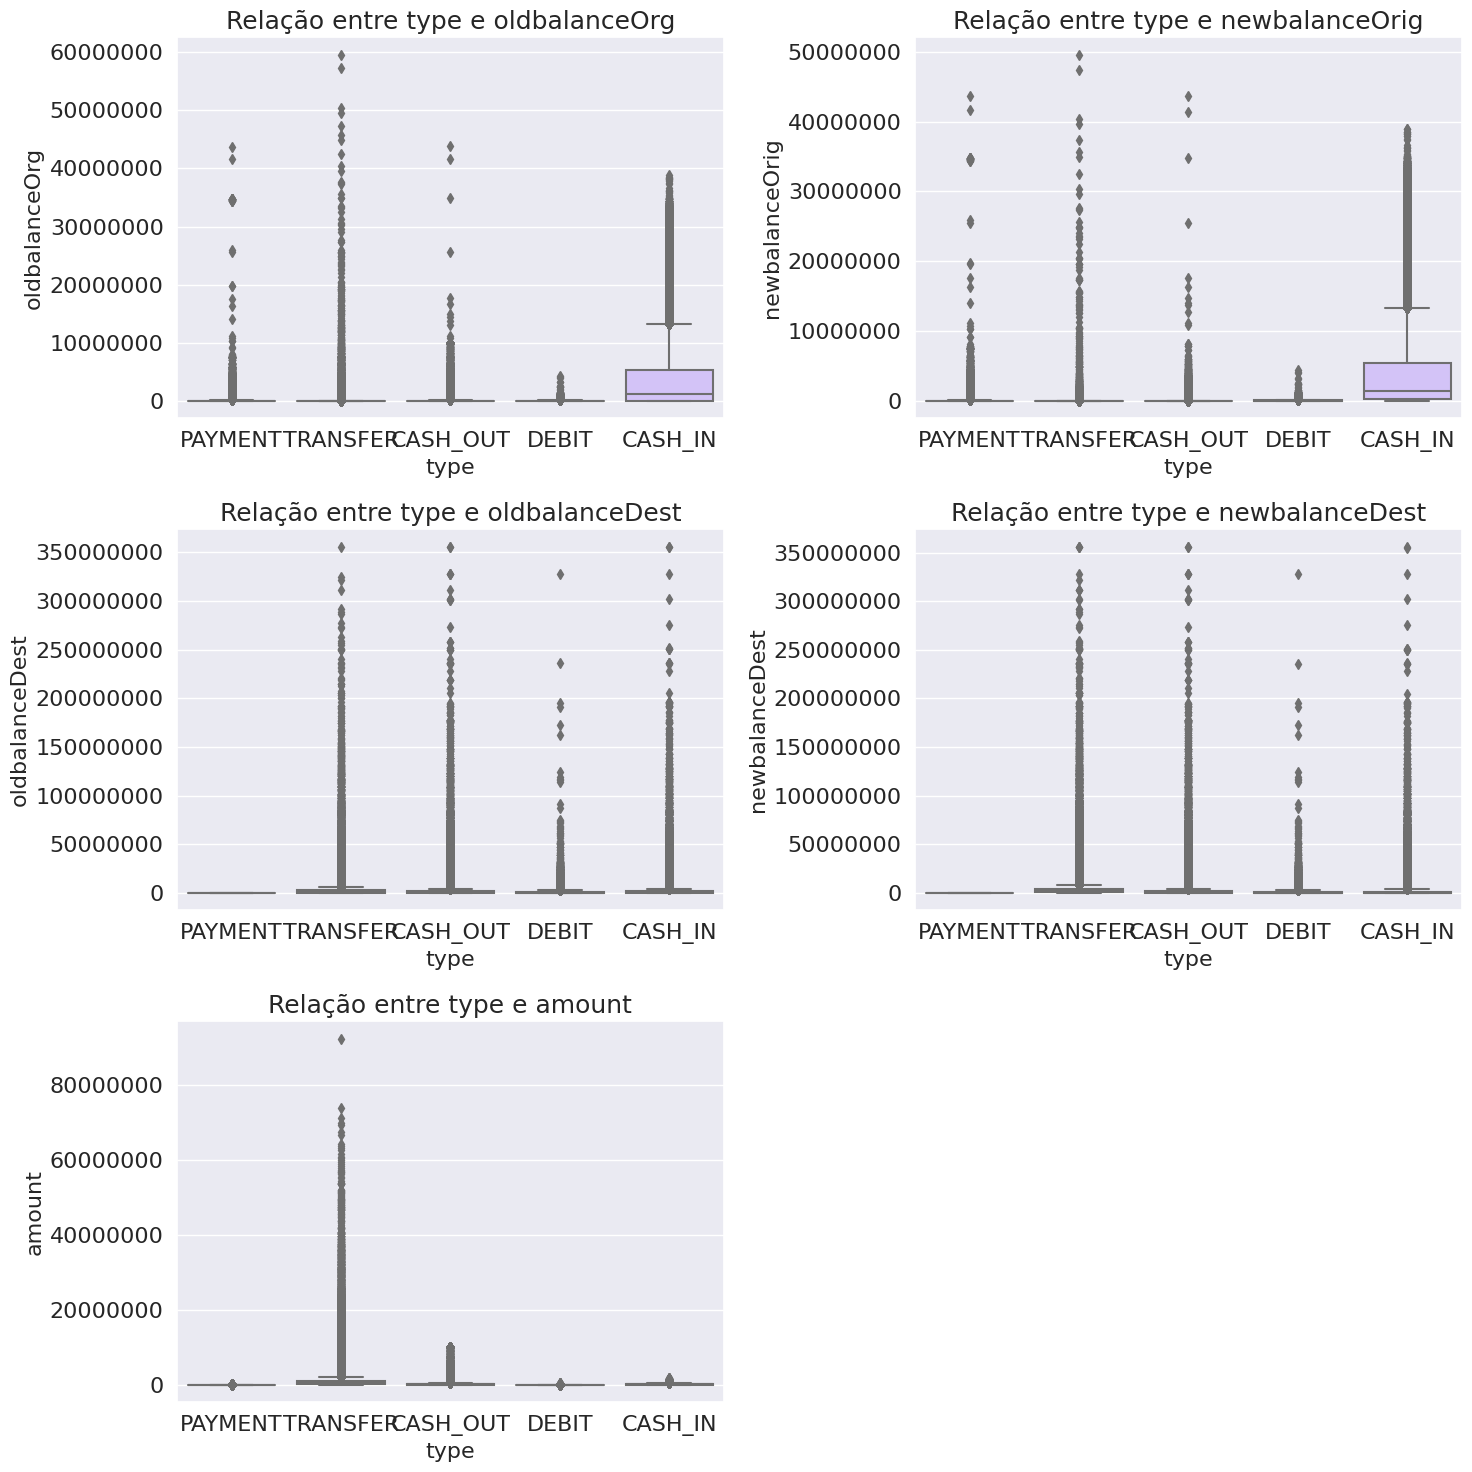

In [76]:
# Função para analisar a relação entre cada variável categórica e cada variável numérica com boxplots
plot_correlation_categorical_numerical(df, categorias, numericas)

## 4.4) Os boxplot acima, podem ser melhor vistos e explicados abaixo

#### 4.4.1) Sobre relação entre Tipos de Transação **oldbalanceOrg**

In [78]:
df.groupby('type')['oldbalanceOrg'].describe().T

type      CASH_IN    CASH_OUT      DEBIT     PAYMENT    TRANSFER
count  1399284.00  2237500.00   41432.00  2151495.00   532909.00
mean   3590463.51    46023.80   68647.34    68216.83    54441.85
std    5291824.90   179132.64  138449.28   198991.08   439981.78
min          0.00        0.00       0.00        0.00        0.00
25%      37768.00        0.00    1518.50        0.00        0.00
50%    1200093.32      556.00   20821.11    10530.00        0.00
75%    5284254.75    31446.24   68806.61    60883.00    26266.00
max   38939424.03 43818855.30 4362014.11 43686616.33 59585040.37

Sobre a relação entre o tipo de transação 'CASH_IN' e 'oldbalanceOrg':

Para o tipo 'CASH_IN', foram registradas 1.399.284 transações, com os seguintes detalhes estatísticos:
- A média do saldo inicial do originador foi de $3.590.463,51.

- O desvio padrão do saldo inicial foi de $5.291.824,90.

- O menor saldo inicial registrado foi $0,00.

- O 1º quartil (25%) das transações teve um saldo inicial de $37.768,00.

- A mediana (50%) das transações apresentou um saldo inicial de $1.200.093,32.

- O 3º quartil (75%) das transações teve um saldo inicial de $5.284.254,75.

- O maior saldo inicial registrado foi de $38.939.424,03.

***

Sobre a relação entre o tipo de transação 'CASH_OUT' e 'oldbalanceOrg':

Para o tipo 'CASH_OUT', foram registradas 2.237.500 transações, com os seguintes detalhes estatísticos:
- A média do saldo inicial do originador foi de $46.023,80.

- O desvio padrão do saldo inicial foi de $179.132,64.

- O menor saldo inicial registrado foi $0,00.

- O 1º quartil (25%) das transações teve um saldo inicial de $0,00.

- A mediana (50%) das transações apresentou um saldo inicial de $556,00.

- O 3º quartil (75%) das transações teve um saldo inicial de $31.446,24.

- O maior saldo inicial registrado foi de $43.818.855,30.

***

Sobre a relação entre o tipo de transação 'DEBIT' e 'oldbalanceOrg':

Para o tipo 'DEBIT', foram registradas 41.432 transações, com os seguintes detalhes estatísticos:
- A média do saldo inicial do originador foi de $68.647,34.

- O desvio padrão do saldo inicial foi de $138.449,28.

- O menor saldo inicial registrado foi $0,00.

- O 1º quartil (25%) das transações teve um saldo inicial de $1.518,50.

- A mediana (50%) das transações apresentou um saldo inicial de $20.821,11.

- O 3º quartil (75%) das transações teve um saldo inicial de $68.806,61.

- O maior saldo inicial registrado foi de $4.362.014,11.

***

Sobre a relação entre o tipo de transação 'PAYMENT' e 'oldbalanceOrg':

Para o tipo 'PAYMENT', foram registradas 2.151.495 transações, com os seguintes detalhes estatísticos:
- A média do saldo inicial do originador foi de $68.216,83.

- O desvio padrão do saldo inicial foi de $198.991,08.

- O menor saldo inicial registrado foi $0,00.

- O 1º quartil (25%) das transações teve um saldo inicial de $0,00.

- A mediana (50%) das transações apresentou um saldo inicial de $10.530,00.

- O 3º quartil (75%) das transações teve um saldo inicial de $60.883,00.

- O maior saldo inicial registrado foi de $43.686.616,33.

***

Sobre a relação entre o tipo de transação 'TRANSFER' e 'oldbalanceOrg':

Para o tipo 'TRANSFER', foram registradas 532.909 transações, com os seguintes detalhes estatísticos:
- A média do saldo inicial do originador foi de $54.441,85.

- O desvio padrão do saldo inicial foi de $439.981,78.

- O menor saldo inicial registrado foi $0,00.

- O 1º quartil (25%) das transações teve um saldo inicial de $0,00.

- A mediana (50%) das transações apresentou um saldo inicial de $0,00.

- O 3º quartil (75%) das transações teve um saldo inicial de $26.266,00.

- O maior saldo inicial registrado foi de $59.585.040,37.


#### 4.4.2) Sobre relação entre Tipos de Transação e **newbalanceOrig**

In [80]:
df.groupby('type')['newbalanceOrig'].describe().T

type      CASH_IN    CASH_OUT      DEBIT     PAYMENT    TRANSFER
count  1399284.00  2237500.00   41432.00  2151495.00   532909.00
mean   3759378.71    17474.19   65161.65    61837.89    10288.16
std    5287487.26   109194.04  137656.58   196991.52   262360.27
min          5.44        0.00       0.00        0.00        0.00
25%     249756.87        0.00       0.00        0.00        0.00
50%    1369114.92        0.00   16632.42        0.00        0.00
75%    5450490.53        0.00   62630.80    49654.13        0.00
max   38946233.02 43686616.33 4359375.18 43673802.21 49585040.37

Sobre a relação entre o tipo de transação 'CASH_IN' e 'newbalanceOrig' (saldo inicial antes da transação):

Para o tipo 'CASH_IN', houve um total de 1.399.284 transações, com os seguintes detalhes estatísticos:
- A média do saldo inicial foi de $3.759.378.

- O desvio padrão foi de $5.287.487.

- O valor mínimo do saldo inicial foi $5,44.

- O 1º quartil (25%) das transações apresentou um saldo inicial de $249.756,87.

- A mediana (50%) das transações mostrou um saldo inicial de $1.369.114,92.

- O 3º quartil (75%) das transações teve um saldo inicial de $5.450.490,53.

- O valor máximo do saldo inicial foi de $38.946.233,02.

***

Sobre a relação entre o tipo de transação 'CASH_OUT' e 'newbalanceOrig' (saldo inicial antes da transação):

Para o tipo 'CASH_OUT', houve um total de 2.237.500 transações, com os seguintes detalhes estatísticos:
- A média do saldo inicial foi de $17.474,19.

- O desvio padrão foi de $109.194,04.

- O valor mínimo do saldo inicial foi $0,00.

- O 1º quartil (25%) das transações apresentou um saldo inicial de $0,00.

- A mediana (50%) das transações mostrou um saldo inicial de $0,00.

- O 3º quartil (75%) das transações teve um saldo inicial de $0,00.

- O valor máximo do saldo inicial foi de $43.686.616,33.

***

Sobre a relação entre o tipo de transação 'DEBIT' e 'newbalanceOrig' (saldo inicial antes da transação):

Para o tipo 'DEBIT', houve um total de 41.432 transações, com os seguintes detalhes estatísticos:
- A média do saldo inicial foi de $65.161,65.

- O desvio padrão foi de $137.656,58.

- O valor mínimo do saldo inicial foi $0,00.

- O 1º quartil (25%) das transações apresentou um saldo inicial de $0,00.

- A mediana (50%) das transações mostrou um saldo inicial de $16.632,42.

- O 3º quartil (75%) das transações teve um saldo inicial de $62.630,80.

- O valor máximo do saldo inicial foi de $4.359.375,18.

***

Sobre a relação entre o tipo de transação 'PAYMENT' e 'newbalanceOrig' (saldo inicial antes da transação):

Para o tipo 'PAYMENT', houve um total de 2.151.495 transações, com os seguintes detalhes estatísticos:
- A média do saldo inicial foi de $61.837,89.

- O desvio padrão foi de $196.991,52.

- O valor mínimo do saldo inicial foi $0,00.

- O 1º quartil (25%) das transações apresentou um saldo inicial de $0,00.

- A mediana (50%) das transações mostrou um saldo inicial de $0,00.

- O 3º quartil (75%) das transações teve um saldo inicial de $49.654,13.

- O valor máximo do saldo inicial foi de $43.673.802,21.

***

Sobre a relação entre o tipo de transação 'TRANSFER' e 'newbalanceOrig' (saldo inicial antes da transação):

Para o tipo 'TRANSFER', houve um total de 532.909 transações, com os seguintes detalhes estatísticos:
- A média do saldo inicial foi de $10.288,16.

- O desvio padrão foi de $262.360,27.

- O valor mínimo do saldo inicial foi $0,00.

- O 1º quartil (25%) das transações apresentou um saldo inicial de $0,00.

- A mediana (50%) das transações mostrou um saldo inicial de $0,00.

- O 3º quartil (75%) das transações teve um saldo inicial de $0,00.

- O valor máximo do saldo inicial foi de $49.585.040,37.

#### 4.4.3) Sobre relação entre Tipos de Transação e **oldbalanceDest**

In [81]:
df.groupby('type')['oldbalanceDest'].describe().T

type       CASH_IN     CASH_OUT        DEBIT    PAYMENT     TRANSFER
count   1399284.00   2237500.00     41432.00 2151495.00    532909.00
mean    1587918.80   1497757.89   1493135.77       0.00   2567605.72
std     3713923.25   3633876.46   4386970.30       0.00   6037846.06
min           0.00         0.00        85.00       0.00         0.00
25%      161260.77    114685.93    130025.08       0.00    224935.36
50%      547137.31    488098.51    424460.41       0.00   1015903.17
75%     1619594.28   1510450.46   1372974.61       0.00   2753798.43
max   355553416.30 356015889.35 327827763.42       0.00 355380483.53

Sobre a relação entre o tipo de transação 'CASH_IN' e 'oldbalanceDest' (saldo anterior do destinatário antes da transação):

Para o tipo 'CASH_IN', foram realizadas 1.399.284 transações, com os seguintes detalhes estatísticos:
- A média do saldo anterior do destinatário foi de $1.587.918,80.

- O desvio padrão foi de $3.713.923,25.

- O saldo anterior mínimo do destinatário foi $0,00.

- O 1º quartil (25%) das transações teve um saldo anterior do destinatário de $161.260,77.

- A mediana (50%) das transações mostrou um saldo anterior do destinatário de $547.137,31.

- O 3º quartil (75%) das transações teve um saldo anterior do destinatário de $1.619.594,28.

- O saldo anterior máximo do destinatário foi de $355.553.416,30.

***

Sobre a relação entre o tipo de transação 'CASH_OUT' e 'oldbalanceDest' (saldo anterior do destinatário antes da transação):

Para o tipo 'CASH_OUT', foram realizadas 2.237.500 transações, com os seguintes detalhes estatísticos:
- A média do saldo anterior do destinatário foi de $1.497.757,89.

- O desvio padrão foi de $3.633.876,46.

- O saldo anterior mínimo do destinatário foi $0,00.

- O 1º quartil (25%) das transações teve um saldo anterior do destinatário de $114.685,93.

- A mediana (50%) das transações mostrou um saldo anterior do destinatário de $488.098,51.

- O 3º quartil (75%) das transações teve um saldo anterior do destinatário de $1.510.450,46.

- O saldo anterior máximo do destinatário foi de $356.015.889,35.

***

Sobre a relação entre o tipo de transação 'DEBIT' e 'oldbalanceDest' (saldo anterior do destinatário antes da transação):

Para o tipo 'DEBIT', foram realizadas 41.432 transações, com os seguintes detalhes estatísticos:
- A média do saldo anterior do destinatário foi de $1.493.135,77.

- O desvio padrão foi de $4.386.970,30.

- O saldo anterior mínimo do destinatário foi $85,00.

- O 1º quartil (25%) das transações teve um saldo anterior do destinatário de $130.025,08.

- A mediana (50%) das transações mostrou um saldo anterior do destinatário de $424.460,41.

- O 3º quartil (75%) das transações teve um saldo anterior do destinatário de $1.372.974,61.

- O saldo anterior máximo do destinatário foi de $327.827.763,42.

***

Sobre a relação entre o tipo de transação 'PAYMENT' e 'oldbalanceDest' (saldo anterior do destinatário antes da transação):

Para o tipo 'PAYMENT', foram realizadas 2.151.495 transações, com os seguintes detalhes estatísticos:
- A média do saldo anterior do destinatário foi de $0,00 (sem saldo anterior para transações de pagamento).
- O desvio padrão foi de $0,00.

- O saldo anterior mínimo do destinatário foi $0,00.

- O 1º quartil (25%) das transações teve um saldo anterior do destinatário de $0,00.

- A mediana (50%) das transações mostrou um saldo anterior do destinatário de $0,00.

- O 3º quartil (75%) das transações teve um saldo anterior do destinatário de $0,00.

- O saldo anterior máximo do destinatário foi de $0,00.

***

Sobre a relação entre o tipo de transação 'TRANSFER' e 'oldbalanceDest' (saldo anterior do destinatário antes da transação):

Para o tipo 'TRANSFER', foram realizadas 532.909 transações, com os seguintes detalhes estatísticos:
- A média do saldo anterior do destinatário foi de $2.567.605,72.

- O desvio padrão foi de $6.037.846,06.

- O saldo anterior mínimo do destinatário foi $0,00.

- O 1º quartil (25%) das transações teve um saldo anterior do destinatário de $224.935,36.

- A mediana (50%) das transações mostrou um saldo anterior do destinatário de $1.015.903,17.

- O 3º quartil (75%) das transações teve um saldo anterior do destinatário de $2.753.798,43.

- O saldo anterior máximo do destinatário foi de $355.380.483,53.

#### 4.4.4) Sobre relação entre Tipos de Transação e **newbalanceDest**

In [82]:
df.groupby('type')['newbalanceDest'].describe().T

type       CASH_IN     CASH_OUT        DEBIT    PAYMENT     TRANSFER
count   1399284.00   2237500.00     41432.00 2151495.00    532909.00
mean    1467105.39   1691326.07   1513003.47       0.00   3554566.83
std     3712985.25   3663007.57   4395708.01       0.00   7387613.66
min           0.00         0.00         0.00       0.00         0.00
25%       42746.28    285896.99    136507.52       0.00    753693.41
50%      385751.36    687606.71    439328.87       0.00   1725375.07
75%     1465845.82   1741879.42   1404071.50       0.00   3795985.78
max   355381433.61 356179278.92 327852121.45       0.00 356015889.35

Sobre a relação entre o tipo de transação 'CASH_IN' e 'newbalanceDest' (novo saldo do destinatário após a transação):

Para o tipo 'CASH_IN', foram realizadas 1.399.284 transações, com os seguintes detalhes estatísticos:
- A média do novo saldo do destinatário foi de $1.467.105,39.

- O desvio padrão foi de $3.712.985,25.

- O novo saldo mínimo do destinatário foi $0,00.

- O 1º quartil (25%) das transações teve um novo saldo do destinatário de $42.746,28.

- A mediana (50%) das transações mostrou um novo saldo do destinatário de $385.751,36.

- O 3º quartil (75%) das transações teve um novo saldo do destinatário de $1.465.845,82.

- O novo saldo máximo do destinatário foi de $355.381.433,61.

***

Sobre a relação entre o tipo de transação 'CASH_OUT' e 'newbalanceDest' (novo saldo do destinatário após a transação):

Para o tipo 'CASH_OUT', foram realizadas 2.237.500 transações, com os seguintes detalhes estatísticos:
- A média do novo saldo do destinatário foi de $1.691.326,07.

- O desvio padrão foi de $3.663.007,57.

- O novo saldo mínimo do destinatário foi $0,00.

- O 1º quartil (25%) das transações teve um novo saldo do destinatário de $285.896,99.

- A mediana (50%) das transações mostrou um novo saldo do destinatário de $687.606,71.

- O 3º quartil (75%) das transações teve um novo saldo do destinatário de $1.741.879,42.

- O novo saldo máximo do destinatário foi de $356.179.278,92.

***

Sobre a relação entre o tipo de transação 'DEBIT' e 'newbalanceDest' (novo saldo do destinatário após a transação):

Para o tipo 'DEBIT', foram realizadas 41.432 transações, com os seguintes detalhes estatísticos:
- A média do novo saldo do destinatário foi de $1.513.003,47.

- O desvio padrão foi de $4.395.708,01.

- O novo saldo mínimo do destinatário foi $0,00.

- O 1º quartil (25%) das transações teve um novo saldo do destinatário de $136.507,52.

- A mediana (50%) das transações mostrou um novo saldo do destinatário de $439.328,87.

- O 3º quartil (75%) das transações teve um novo saldo do destinatário de $1.404.071,50.

- O novo saldo máximo do destinatário foi de $327.852.121,45.

***

Sobre a relação entre o tipo de transação 'PAYMENT' e 'newbalanceDest' (novo saldo do destinatário após a transação):

Para o tipo 'PAYMENT', foram realizadas 2.151.495 transações, com os seguintes detalhes estatísticos:
- Neste caso, não há novo saldo para transações de 'PAYMENT'. 
Os valores de média, desvio padrão, quartis e máximo são todos zero.

***

Sobre a relação entre o tipo de transação 'TRANSFER' e 'newbalanceDest' (novo saldo do destinatário após a transação):

Para o tipo 'TRANSFER', foram realizadas 532.909 transações, com os seguintes detalhes estatísticos:
- A média do novo saldo do destinatário foi de $3.554.566,83.

- O desvio padrão foi de $7.387.613,66.

- O novo saldo mínimo do destinatário foi $0,00.

- O 1º quartil (25%) das transações teve um novo saldo do destinatário de $753.693,41.

- A mediana (50%) das transações mostrou um novo saldo do destinatário de $1.725.375,07.

- O 3º quartil (75%) das transações teve um novo saldo do destinatário de $3.795.985,78.

- O novo saldo máximo do destinatário foi de $356.015.889,35.

#### 4.4.5) Sobre relação entre Tipos de Transação e **amount**

In [83]:
df.groupby('type')['amount'].describe().T

type     CASH_IN    CASH_OUT     DEBIT    PAYMENT    TRANSFER
count 1399284.00  2237500.00  41432.00 2151495.00   532909.00
mean   168920.24   176273.96   5483.67   13057.60   910647.01
std    126508.26   175329.74  13318.54   12556.45  1879573.53
min         0.04        0.00      0.55       0.02        2.60
25%     70510.18    72669.65   1500.18    4383.82   215905.35
50%    143427.71   147072.18   3048.99    9482.19   486308.39
75%    239899.09   246539.48   5479.18   17561.22   974958.00
max   1915267.90 10000000.00 569077.51  238637.98 92445516.64

Sobre a relação entre o tipo de transação 'CASH_IN' e 'amount':

Para o tipo 'CASH_IN', foram registradas 1.399.284 transações, com os seguintes detalhes estatísticos:
- A média do montante (amount) foi de $168.920,24.

- O desvio padrão do montante foi de $126.508,26.

- O menor montante registrado foi $0,04.

- O 1º quartil (25%) das transações teve um montante de $70.510,18.

- A mediana (50%) das transações apresentou um montante de $143.427,71.

- O 3º quartil (75%) das transações teve um montante de $239.899,09.

- O maior montante registrado foi de $1.915.267,90.

***

Sobre a relação entre o tipo de transação 'CASH_OUT' e 'amount':

Para o tipo 'CASH_OUT', foram registradas 2.237.500 transações, com os seguintes detalhes estatísticos:
- A média do montante (amount) foi de $176.273,96.

- O desvio padrão do montante foi de $175.329,74.

- O menor montante registrado foi $0,00.

- O 1º quartil (25%) das transações teve um montante de $72.669,65.

- A mediana (50%) das transações apresentou um montante de $147.072,18.

- O 3º quartil (75%) das transações teve um montante de $246.539,48.

- O maior montante registrado foi de $10.000.000,00.

***

Sobre a relação entre o tipo de transação 'DEBIT' e 'amount':

Para o tipo 'DEBIT', foram registradas 41.432 transações, com os seguintes detalhes estatísticos:
- A média do montante (amount) foi de $5.483,67.

- O desvio padrão do montante foi de $13.318,54.

- O menor montante registrado foi $0,55.

- O 1º quartil (25%) das transações teve um montante de $1.500,18.

- A mediana (50%) das transações apresentou um montante de $3.048,99.

- O 3º quartil (75%) das transações teve um montante de $5.479,18.

- O maior montante registrado foi de $569.077,51.

***

Sobre a relação entre o tipo de transação 'PAYMENT' e 'amount':

Para o tipo 'PAYMENT', foram registradas 2.151.495 transações, com os seguintes detalhes estatísticos:
- A média do montante (amount) foi de $13.057,60.

- O desvio padrão do montante foi de $12.556,45.

- O menor montante registrado foi $0,02.

- O 1º quartil (25%) das transações teve um montante de $4.383,82.

- A mediana (50%) das transações apresentou um montante de $9.482,19.

- O 3º quartil (75%) das transações teve um montante de $17.561,22.

- O maior montante registrado foi de $238.637,98.

***

Sobre a relação entre o tipo de transação 'TRANSFER' e 'amount':

Para o tipo 'TRANSFER', foram registradas 532.909 transações, com os seguintes detalhes estatísticos:
- A média do montante (amount) foi de $910.647,01.

- O desvio padrão do montante foi de $1.879.573,53.

- O menor montante registrado foi $2,60.

- O 1º quartil (25%) das transações teve um montante de $215.905,35.

- A mediana (50%) das transações apresentou um montante de $486.308,39.

- O 3º quartil (75%) das transações teve um montante de $974.958,00.

- O maior montante registrado foi de $92.445.516,64.


***
### 4.5) Outras análises do dataset

### 4.5.1) Sobre as transações fraudulentas

In [104]:
print("Quais são os tipos de transações fraudulentas?", df.loc[df['isFraud'] == 1].type.drop_duplicates().values)

Quais são os tipos de transações fraudulentas? ['TRANSFER' 'CASH_OUT']


In [106]:
dfFraud = df.loc[df['isFraud'] == 1]
dfNonFraud = df.loc[df['isFraud'] == 0]

print("\nQuantas origens únicas existem nas transações de transferência fraudulenta? {} / {}".format(len(dfFraud.loc[dfFraud.type == 'TRANSFER'].nameOrig.drop_duplicates().values),len(dfFraud.loc[dfFraud.type == 'TRANSFER'])))

print("\nQuantos destinos únicos existem nas transações de transferência fraudulenta? {} / {}".format(len(dfFraud.loc[dfFraud.type == 'TRANSFER'].nameDest.drop_duplicates().values),len(dfFraud.loc[dfFraud.type == 'TRANSFER'])))

print("\nQuantas origens únicas existem em transações de saque fraudulentas? {} / {}".format(len(dfFraud.loc[dfFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates().values),len(dfFraud.loc[dfFraud.type == 'CASH_OUT'])))

print("\nQuantos destinos exclusivos existem em transações de saque fraudulentas? {} / {}".format(len(dfFraud.loc[dfFraud.type == 'CASH_OUT'].nameDest.drop_duplicates().values),len(dfFraud.loc[dfFraud.type == 'CASH_OUT'])))


Quantas origens únicas existem nas transações de transferência fraudulenta? 4097 / 4097

Quantos destinos únicos existem nas transações de transferência fraudulenta? 4097 / 4097

Quantas origens únicas existem em transações de saque fraudulentas? 4116 / 4116

Quantos destinos exclusivos existem em transações de saque fraudulentas? 4091 / 4116


In [91]:
dfFraudTransfer = dfFraud.loc[dfFraud.type == 'TRANSFER']
dfFraudCashout = dfFraud.loc[dfFraud.type == 'CASH_OUT']

print("Quantas transações de transferência fraudulentas têm destinos que são origens de transações de saque fraudulentas ? {}".\
      format(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig.unique()).sum()))

print("\nQuantas transações de transferência fraudulenta têm destinos originados em transações de saque genuínas? {}".\
      format(dfFraudTransfer.nameDest.isin(dfNonFraud.loc[dfNonFraud.type == 'CASH_OUT'].nameOrig.unique()).sum()))
print("Quantas transações de transferência genuínas têm destinos originados em transações de saque fraudulentas? {}".\
      format(dfNonFraud.loc[dfNonFraud.type == 'TRANSFER'].nameDest.isin(dfFraudCashout.nameOrig.unique()).sum()))

print("\nQuantas transações de transferência genuínas têm destinos que são destinos em transações de transferência fraudulentas? {}".\
      format(dfNonFraud.loc[dfNonFraud.type == 'TRANSFER'].nameDest.isin(dfFraudTransfer.nameDest.unique()).sum()))
print("Quantas transações de transferência genuínas têm origens que são destinos em transações de transferência fraudulentas? {}".\
      format(dfNonFraud.loc[dfNonFraud.type == 'TRANSFER'].nameOrig.isin(dfFraudTransfer.nameDest.unique()).sum()))
print("Quantas transações de transferência genuínas têm origem em transações de transferência fraudulentas? {}".\
      format(dfNonFraud.loc[dfNonFraud.type == 'TRANSFER'].nameOrig.isin(dfFraudTransfer.nameOrig.unique()).sum()))
print("Quantas transações de transferência genuínas têm destinos que são origens de transações de transferência fraudulentas? {}".\
      format(dfNonFraud.loc[dfNonFraud.type == 'TRANSFER'].nameDest.isin(dfFraudTransfer.nameOrig.unique()).sum()))

Quantas transações de transferência fraudulentas têm destinos que são origens de transações de saque fraudulentas ? 0

Quantas transações de transferência fraudulenta têm destinos originados em transações de saque genuínas? 3
Quantas transações de transferência genuínas têm destinos originados em transações de saque fraudulentas? 0

Quantas transações de transferência genuínas têm destinos que são destinos em transações de transferência fraudulentas? 1701
Quantas transações de transferência genuínas têm origens que são destinos em transações de transferência fraudulentas? 1
Quantas transações de transferência genuínas têm origem em transações de transferência fraudulentas? 2
Quantas transações de transferência genuínas têm destinos que são origens de transações de transferência fraudulentas? 0


In [107]:
print('Min, Max de transações fraudulentas: {} - {}'.format(dfFraud.amount.min(),dfFraud.amount.max()))
print('\nMin, Max de transações não fraudulentas: {} - {}'.format(dfNonFraud.amount.min(),dfNonFraud.amount.max()))

Min, Max de transações fraudulentas: 0.0 - 10000000.0

Min, Max de transações não fraudulentas: 0.01 - 92445516.64


In [84]:
end=timeit.default_timer()

check_time(start, end)

0.0 dias 1.0 horas 10.0 minutos e 37.84 segundos
